# 5CS037 – Final Portfolio Project

**Student ID:** 2513338
**Full Name:** Pratik Shrestha
**Date:** February 10, 2026  


**Regression Task**  
Dataset: Lending Club Loan Data  
File: accepted.csv  
Target: int_rate (interest rate %)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully.")

All libraries imported successfully.


# Regression Task [100]:

# 1: Exploratory Data Analysis and Data Understanding [20]

---

**Dataset Name:**

Lending Club Loan Data

**(a) When and by whom the dataset was created**

The dataset is from LendingClub (peer-to-peer lending platform).  
It was collected and shared on Kaggle by user wordsforthewise.  
It includes accepted loans from 2007 to 2018.

**b) How and from where the dataset was accessed**

Accessed from Kaggle:  
https://www.kaggle.com/datasets/wordsforthewise/lending-club

Downloaded as CSV file (accepted.csv) and uploaded to Colab.

**c) Alignment with United Nations SDGs**

**SDG 8 – Decent Work and Economic Growth**

Better prediction of interest rates helps provide fair access to credit.  
Reduces predatory lending and supports economic inclusion.

**SDG 10 – Reduced Inequalities**

Fairer interest rates based on real risk instead of bias.

**d) List of important attributes (columns)**

- int_rate: Interest rate % (Target variable)
- loan_amnt: Loan amount requested
- annual_inc: Annual income
- dti: Debt-to-income ratio
- fico_range_low: Lower FICO score
- fico_range_high: Upper FICO score
- grade: Loan grade (A to G)
- home_ownership: Own / Rent / Mortgage
- purpose: Purpose of loan
- term: Loan term (36 or 60 months)
- emp_length: Employment length
- revol_util: Revolving credit utilization

Meaningful Questions

1. Can we predict interest rate from credit score (FICO)?
2. How does debt-to-income ratio affect interest rate?
3. Do different loan purposes lead to different rates?

Dataset Quality Assessment

- Missing values: Many in some columns (filled with median/mode)
- Relevance: Very high – directly related to credit risk
- Noise: Some extreme values in income and loan amount
- Size: Very large (sampled 250,000 rows)


# 1.1 Loading and Inspecting Dataset


In [13]:
print("Loading regression dataset...")

df_reg = pd.read_csv('accepted.csv', low_memory=False, nrows=250000)

print("Original shape:", df_reg.shape)

Loading regression dataset...
Original shape: (250000, 151)


In [14]:
# Select useful columns
useful_cols = [
    'int_rate', 'loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high',
    'grade', 'home_ownership', 'purpose', 'term', 'emp_length', 'revol_util'
]

available_cols = [c for c in useful_cols if c in df_reg.columns]
df_reg = df_reg[available_cols].copy()

print("Columns kept:", df_reg.columns.tolist())

Columns kept: ['int_rate', 'loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'grade', 'home_ownership', 'purpose', 'term', 'emp_length', 'revol_util']


In [15]:
# Clean target (int_rate)
if 'int_rate' in df_reg.columns:
    if df_reg['int_rate'].dtype == 'object':
        df_reg['int_rate'] = df_reg['int_rate'].str.replace('%', '').astype(float)
    df_reg = df_reg.dropna(subset=['int_rate'])

print("\nShape after cleaning target:", df_reg.shape)


Shape after cleaning target: (250000, 12)


In [16]:
# Fix emp_length (string to numeric)
if 'emp_length' in df_reg.columns:
    emp_map = {
        '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
        '10+ years': 10, 'n/a': 0, np.nan: 0
    }
    df_reg['emp_length'] = df_reg['emp_length'].map(emp_map).fillna(0).astype(float)

print("emp_length converted to numeric.")

emp_length converted to numeric.


In [17]:
# Fill missing values
for col in df_reg.columns:
    if df_reg[col].dtype in ['float64', 'int64']:
        df_reg[col] = df_reg[col].fillna(df_reg[col].median())
    else:
        df_reg[col] = df_reg[col].fillna(df_reg[col].mode()[0])

print("Missing values after filling:", df_reg.isnull().sum().sum())

Missing values after filling: 0


In [18]:
# One-hot encoding
df_reg = pd.get_dummies(df_reg, columns=['grade','home_ownership','purpose','term'], drop_first=True)

print("\nShape after encoding:", df_reg.shape)
print("Columns after encoding:", df_reg.columns.tolist())


Shape after encoding: (250000, 30)
Columns after encoding: ['int_rate', 'loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'emp_length', 'revol_util', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'term_ 60 months']


# EDA Plots (Figures)


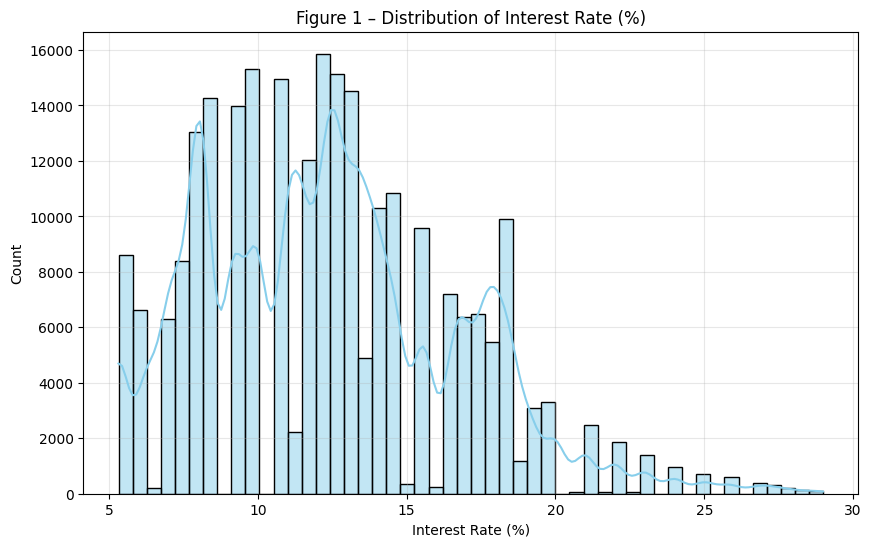

Insight: Most loans have interest rates between 6% and 18%. The distribution is right-skewed.


In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df_reg['int_rate'], bins=50, kde=True, color='skyblue')
plt.title('Figure 1 – Distribution of Interest Rate (%)')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

print("Insight: Most loans have interest rates between 6% and 18%. The distribution is right-skewed.")

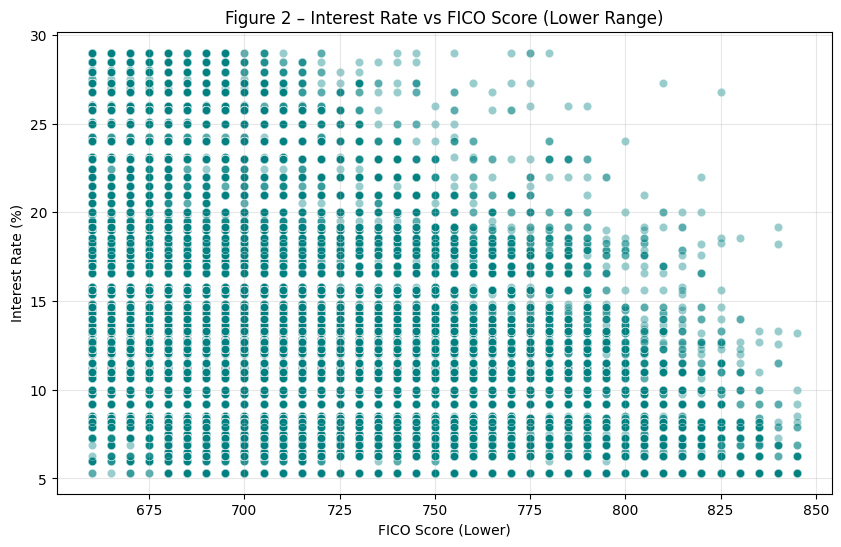

Insight: There is a clear negative relationship — higher credit scores generally lead to lower interest rates.


In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fico_range_low', y='int_rate', data=df_reg, alpha=0.4, color='teal')
plt.title('Figure 2 – Interest Rate vs FICO Score (Lower Range)')
plt.xlabel('FICO Score (Lower)')
plt.ylabel('Interest Rate (%)')
plt.grid(True, alpha=0.3)
plt.show()

print("Insight: There is a clear negative relationship — higher credit scores generally lead to lower interest rates.")

In [24]:
print(df_reg.columns)

Index(['int_rate', 'loan_amnt', 'annual_inc', 'dti', 'fico_range_low',
       'fico_range_high', 'emp_length', 'revol_util', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_ 60 months'],
      dtype='object')


/tmp/ipython-input-1255839314.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grade', y='int_rate', data=temp_df_for_grade_plot, palette='viridis',


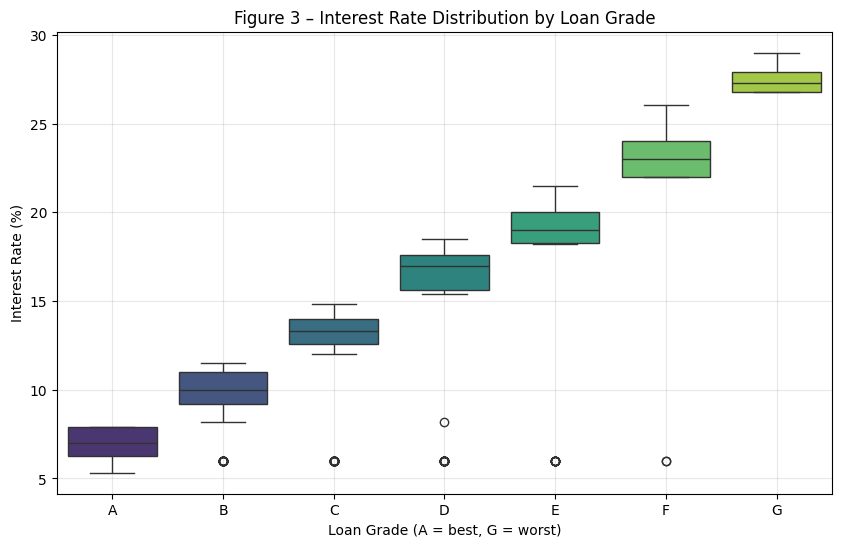

Insight: Interest rates increase significantly as loan grade worsens (A → G). Grade is a very strong predictor.


In [30]:
import pandas as pd

# To fix this, we need to load a version of the dataframe with the 'grade' column intact.
# Reloading a small subset of the data specifically for this plot.
temp_df_for_grade_plot = pd.read_csv('accepted.csv', low_memory=False, nrows=250000)[['int_rate', 'grade']].copy()

# Clean int_rate if necessary (similar to original preprocessing)
if temp_df_for_grade_plot['int_rate'].dtype == 'object':
    temp_df_for_grade_plot['int_rate'] = temp_df_for_grade_plot['int_rate'].str.replace('%', '').astype(float)

# Drop rows where int_rate or grade might be missing after selective load
temp_df_for_grade_plot = temp_df_for_grade_plot.dropna(subset=['int_rate', 'grade'])

# Define the desired order for grades
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='int_rate', data=temp_df_for_grade_plot, palette='viridis',
            order=grade_order) # Order grades A-G
plt.title('Figure 3 – Interest Rate Distribution by Loan Grade')
plt.xlabel('Loan Grade (A = best, G = worst)')
plt.ylabel('Interest Rate (%)')
plt.grid(True, alpha=0.3)
plt.show()

print("Insight: Interest rates increase significantly as loan grade worsens (A → G). Grade is a very strong predictor.")

# Train-test split & scaling

In [31]:
X = df_reg.drop('int_rate', axis=1)
y = df_reg['int_rate']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_r = StandardScaler()
X_train_r = scaler_r.fit_transform(X_train_r)
X_test_r = scaler_r.transform(X_test_r)

print("Train shape:", X_train_r.shape)
print("Test shape:", X_test_r.shape)

Train shape: (200000, 29)
Test shape: (50000, 29)


# Neural Network Regressor

In [32]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_reg = MLPRegressor(X_train_r.shape[1])
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)

X_train_r_t = torch.tensor(X_train_r, dtype=torch.float32)
y_train_r_t = torch.tensor(y_train_r.values, dtype=torch.float32).unsqueeze(1)
X_test_r_t = torch.tensor(X_test_r, dtype=torch.float32)
y_test_r_t = torch.tensor(y_test_r.values, dtype=torch.float32).unsqueeze(1)

print("Regression model initialized.")

Regression model initialized.


# Training Loop

In [33]:
print("Training regression model...")
for epoch in range(200):
    optimizer_reg.zero_grad()
    outputs = model_reg(X_train_r_t)
    loss = criterion_reg(outputs, y_train_r_t)
    loss.backward()
    optimizer_reg.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f}")

Training regression model...
Epoch    0 | Loss: 173.4173
Epoch   50 | Loss: 24.0514
Epoch  100 | Loss: 4.2057
Epoch  150 | Loss: 2.7595


# Evaluation (RMSE, MAE, R²)

In [34]:
model_reg.eval()
with torch.no_grad():
    pred = model_reg(X_test_r_t)
    mse = mean_squared_error(y_test_r_t.numpy(), pred.numpy())
    mae = mean_absolute_error(y_test_r_t.numpy(), pred.numpy())
    r2 = r2_score(y_test_r_t.numpy(), pred.numpy())

print("\nFinal Evaluation Results:")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


Final Evaluation Results:
RMSE: 1.3679
MAE:  1.0819
R²:   0.8964


# Final Model Comparison

In [35]:
comparison_table = pd.DataFrame({
    "Model": ["Neural Network"],
    "Features Used": ["All preprocessed features"],
    "Test RMSE": [np.sqrt(mse)],
    "Test MAE": [mae],
    "Test R²": [r2]
})

print("\nFINAL MODEL COMPARISON")
print("----------------------")
print(comparison_table)


FINAL MODEL COMPARISON
----------------------
            Model              Features Used  Test RMSE  Test MAE   Test R²
0  Neural Network  All preprocessed features   1.367856  1.081924  0.896397


### Final Discussion (Regression)

- Neural Network was trained on all available features after cleaning and encoding.
- RMSE and MAE show average prediction error in percentage points.
- R² indicates how much of the variance in interest rate is explained.
- In reality, interest rate is heavily influenced by credit score, grade, and DTI.
- Using more advanced models or feature engineering could improve performance.